In [1]:
import sys
# in order that the parent directory can be accessed, as this notebook
# is in the 'notebooks/' subdirectory
sys.path[1:1] = ['..']
%load_ext autoreload
%autoreload 2

In [2]:
from bayesianAB.event_stream import generate_cumulative_dataframes_with_extra_columns, simple_dataframe_with_all_stats
from bayesianAB.risk import risk
import pandas as pd

In [3]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## No true difference

If there is zero difference between the two means, then both the _expected loss_ and the _expected gain_ will tend towards zero. If there truly is a positive effect, the expected gain will tend towards the true positive effect, and the expected loss will tend to zero. And finally, if there truly is a negative effect, then the expected loss will tend towards the true effect and the expected gain will tend towards zero.

We see this in the next few plots. The first plot is just one experiment running to a sample size of 100, plotting the expected loss (EL, blue) and the expected gain (EG, orange).

The second plot shows 25 experiments, each running up to a sample size of 500, with the 25 traces of EL on top of each other. The third plot is the same as the second, but with a small positive true effect in order to show that the EL tends towards zero more quickly.

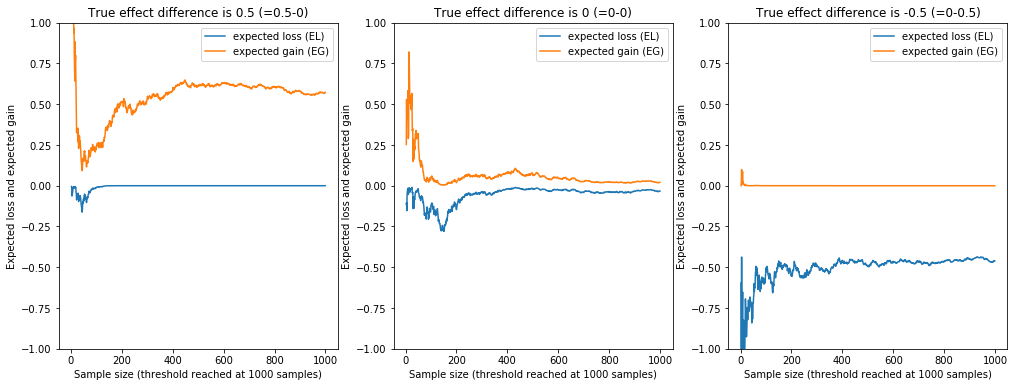

In [4]:
stopping_condition = 'total_sample_size == 1000'

plt.figure(figsize=(17,6))
for subplot_number, means in [(1, [0, 0.5]),
                              (2, [0,0]),
                              (3, [0.5, 0])]:
    plt.subplot(1, 3, subplot_number)
    plt.title('True effect difference is {} (={}-{})'.format(means[1]-means[0], means[1], means[0]))
    plt.ylim(-1, 1)
    sim = simple_dataframe_with_all_stats(
        weights = [0.5, 0.5],
        means = means,
        stdevs = [1, 1],
        stopping_condition = stopping_condition)
    plt.plot(sim.expected_loss, label='expected loss (EL)');
    plt.plot(sim.expected_gain, label='expected gain (EG)');
    plt.xlabel('Sample size (threshold reached at {} samples)'.format(sim.total_sample_size.iloc[-1]))
    plt.ylabel('Expected loss and expected gain')
    plt.legend()

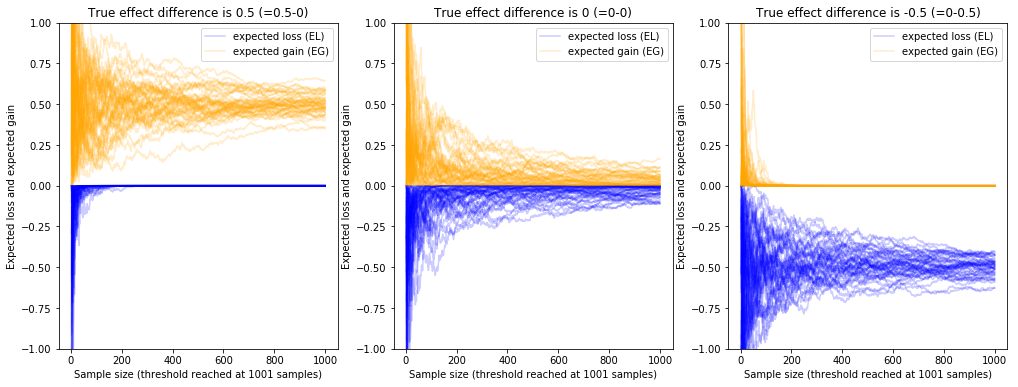

In [5]:
stopping_condition = 'total_sample_size > 1000'

plt.figure(figsize=(17,6))
for subplot_number, means in [(1, [0, 0.5]),
                              (2, [0,0]),
                              (3, [0.5, 0])]:
    plt.subplot(1, 3, subplot_number)
    plt.title('True effect difference is {} (={}-{})'.format(means[1]-means[0], means[1], means[0]))
    plt.ylim(-1, 1)
    for repetition in range(50):
        sim = simple_dataframe_with_all_stats(
            weights = [0.5, 0.5],
            means = means,
            stdevs = [1, 1],
            stopping_condition = stopping_condition)
        plt.plot(sim.expected_loss, label = 'expected loss (EL)', alpha=0.2, color='blue');
        plt.plot(sim.expected_gain, label = 'expected gain (EG)', alpha=0.2, color='orange');
        if repetition == 0: # otherwise, we get too many legends
            plt.legend()
    plt.xlabel('Sample size (threshold reached at {} samples)'.format(sim.total_sample_size.iloc[-1]))
    plt.ylabel('Expected loss and expected gain')

## "Threshold of caring"

The _threshold of caring_ is a heuristic used to decide when to stop the experiment. If we set the _threshold of caring_ to 

$$\tau=0.01$$

then we run the experiment until either:

$$  EL > -\tau $$
or
$$  EG < \tau $$

To investigate this, we need to run simulations where we specify:

 - the true effect, $\Delta$, which is the difference in the true means
 - the _threshold of caring_, $toc$

and then we analyse the final values, after the threshold has been reached, of these three quantities:

 - EL
 - EG
 - estimated effect, $\hat\Delta$, i.e. the difference between the estimate sample means

In [6]:
def simulate_to_the_threshold(runs, true_difference, true_stdev, threshold_of_caring):
    # Always a minimum sample size of 1000
    stopping_condition = """total_sample_size > 1000 \
                            & ( expected_loss > -{threshold_of_caring} \
                              | expected_gain <  {threshold_of_caring} \
                              ) \
                            """.format(**locals())
    many_runs = []
    for _ in range(runs):
        sim = simple_dataframe_with_all_stats(
            weights = [0.5, 0.5],
            # the absolute value of the means doesn't matter, just the difference between them
            means = [7, 7+true_difference],
            stdevs = [true_stdev, true_stdev],
            stopping_condition = stopping_condition)
        # sim.iloc[[-1]] describes the final state of the simulation
        many_runs.append(sim.iloc[[-1]])
    # concatenate the results, one row per simulation, and extract the interesting columns
    return pd.concat(many_runs).reset_index(drop=True)[['total_sample_size', 'expected_loss', 'expected_gain', 'difference_of_means']]

<Figure size 432x288 with 0 Axes>

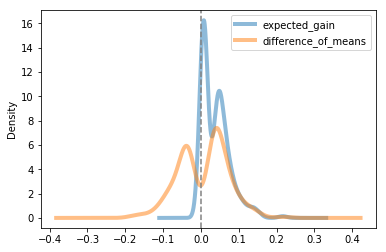

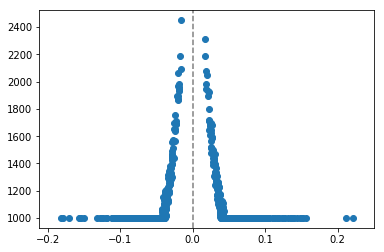

<Figure size 432x288 with 0 Axes>

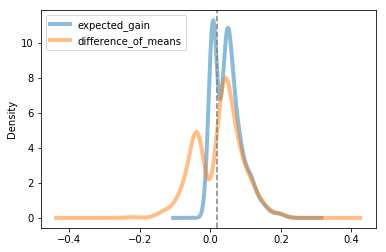

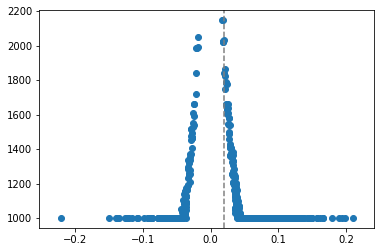

<Figure size 432x288 with 0 Axes>

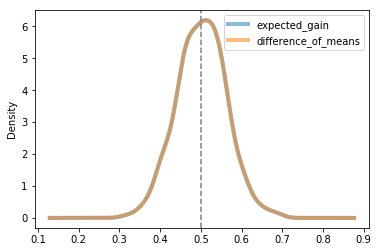

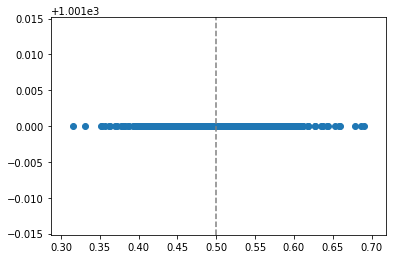

In [13]:
for true_difference in [0, 0.02, 0.5]:
    plt.figure()
    plt.suptitle(true_difference)
    many_sims = simulate_to_the_threshold(runs = 500,
                              true_difference = true_difference,
                              true_stdev=1,
                              threshold_of_caring = 0.01)
    many_sims[['expected_gain', 'difference_of_means']].plot.kde(alpha=0.5, linewidth=4)
    plt.gca().axvline(x=true_difference, color='grey', linestyle='--');
    
    plt.figure()

    plt.scatter(many_sims.difference_of_means, many_sims.total_sample_size)
    plt.gca().axvline(x=true_difference, color='grey', linestyle='--');